In [2]:
# Import external libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [27]:
# load Data

company = 'NVDA' 

start = dt.datetime(2022,1,1)
end = dt.datetime(2023, 1, 1)
data = web.DataReader(company, 'stooq', start, end)
data

,Open,High,Low,Close,Volume
Date,,,,,
2022-12-30,143.340,146.2899,142.330,146.140,3.104898e+07
2022-12-29,144.020,146.8300,142.270,146.030,3.549232e+07
2022-12-28,139.270,142.6200,138.840,140.360,3.510664e+07
2022-12-27,150.740,151.0000,140.560,141.210,4.649023e+07
2022-12-23,151.960,153.3900,148.830,152.060,3.493256e+07
...,...,...,...,...,...
2022-01-07,281.145,283.9530,270.314,272.211,4.103219e+07
2022-01-06,276.139,284.1130,270.394,281.514,4.546111e+07
2022-01-05,289.219,293.8860,275.070,275.779,4.985296e+07


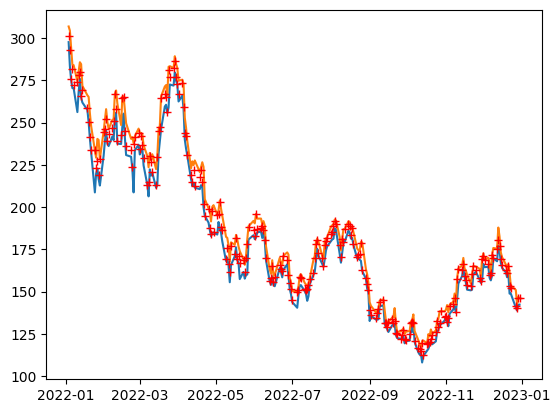

In [40]:
plt.plot(data['Low'])
plt.plot(data['High'])
plt.plot(data['Close'], 'r+')

plt.plot();

In [273]:
# Prepare Data

scaler = MinMaxScaler(feature_range = (0, 1))  # Instance of the MinMaxScaler class

# We apply the the MinMaxScaler to the 'Close' column.
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# .values gives us NumPy array transformed values
# .reshape(-1, 1) reshapes the array into a 
#  single column (required by MinMaxScaler)
# .fit_transform() performs scaling transformation 
#  on the selected column of data

# scaled_data returns data normalized in (0,1) ready to be used
# as neural network inputs

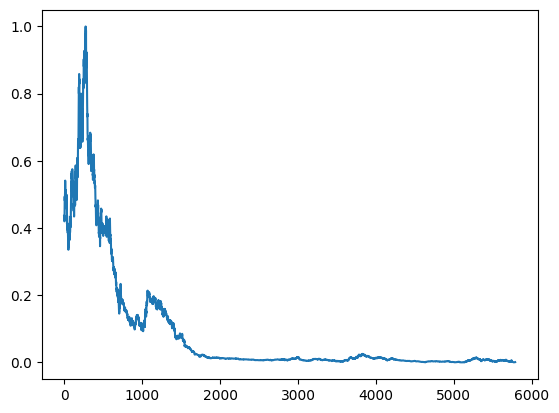

In [274]:
plt.plot(scaled_data)

In [275]:
a = []
for x in range(prediction_days, len(scaled_data)):    
    a.append(scaled_data[x - prediction_days : x])
a = np.array(a)
a
a.ndim

3

In [276]:
b = np.reshape(a, (a.shape[0], a.shape[1], 1))
b
b.ndim

3

In [277]:
141720/2362

60.0

In [278]:
## Training Data

# How many days I want to base my prediction on
prediction_days = 60

# Now two empy lists

x_train = []
y_train = []

# Loop to iterate over the range starting from pred_days and going up to the 
# length of scaled_data arry. This creates the training samples 
for x in range(prediction_days, len(scaled_data)):    
    # From the 60th to the last
    x_train.append(scaled_data[x - prediction_days : x, 0]) # append slice of scaled data array to x_train list
    # the slice is the input features from a training sample.
    # it includes values from 'x - prediction days' to  x
    y_train.append(scaled_data[x, 0])  # Target value for the training sample
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# Reshape in three dimensions: 1. number of training samples
#                              2. number of time steps
#                              3. number of features

The reason for adding the extra dimension is to conform to the input shape expected by the LSTM model. 
In Keras, the input shape for an LSTM layer should be:
 - batch_size, 
 - timesteps, 
 - input_dim, 

where:

 - batch_size corresponds to the number of training samples
 - timesteps corresponds to the number of time steps (in this case, prediction_days)
 - input_dim represents the number of input features at each time step (in this case, 1)

In [ ]:
model = Sequential()  # Initializes a sequen model (linear stack of layers)

model.add(LSTM(units = 50, 
               return_sequences = True, 
               input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Dense is a fully connected layer
                           # Prediction of the next closing value

model.compile(optimizer = 'adam', loss ='mean_squared_error')
model.fit(x_train, y_train, epochs = 25, batch_size = 32) #Training of the model
# given training data, supposed corresponding target values with 25 iteration
# in a batch size of 32

Epoch 1/25
179/179 [==============================] - 18s 74ms/step - loss: 0.0022
Epoch 2/25
179/179 [==============================] - 14s 78ms/step - loss: 8.0629e-04
Epoch 3/25
179/179 [==============================] - 14s 77ms/step - loss: 7.1997e-04
Epoch 4/25
179/179 [==============================] - 13s 75ms/step - loss: 8.2799e-04
Epoch 5/25
179/179 [==============================] - 13s 75ms/step - loss: 5.0895e-04
Epoch 6/25
179/179 [==============================] - 13s 74ms/step - loss: 6.4404e-04
Epoch 7/25
179/179 [==============================] - 13s 74ms/step - loss: 5.0907e-04
Epoch 8/25
179/179 [==============================] - 14s 76ms/step - loss: 5.2028e-04
Epoch 9/25
179/179 [==============================] - 14s 77ms/step - loss: 5.1527e-04
Epoch 10/25
170/179 [===========================>..] - ETA: 0s - loss: 4.6861e-04

Overall, this code sets up a three-layer LSTM model with dropout regularization and a final dense layer for predicting stock prices. The model is trained using the provided training data and target values.

In [256]:
len(total_dataset) - len(test_data) - prediction_days

2362

In [257]:
'''
Test the Model Accuracy on Existing Data
'''

#Load Test Data
test_start = dt.datetime(2022, 1, 1)
test_end = dt.datetime.now()  

test_data = web.DataReader(company, 'stooq', test_start, test_end)

actual_prices = test_data['Close'].values
# Combine the data from training and test 
total_dataset = pd.concat((data['Close'], test_data['Close']), axis = 0)


model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
# Like this we are able to start in the index omitting the test data and the 
# extra 'prediction_days'
model_inputs = model_inputs.reshape(-1, 1)  #unknown no. of rows, 1 no. of column
model_inputs = scaler.transform(model_inputs) # We normalize the new test data

In [258]:
# Make predictions on test data

x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x - prediction_days:x, 0])  # Same iteration as before
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [259]:
x_test

array([[[3.00522388e-02],
        [3.16395145e-02],
        [3.26397156e-02],
        ...,
        [1.07902132e-03],
        [3.50613982e-04],
        [0.00000000e+00]],

       [[3.16395145e-02],
        [3.26397156e-02],
        [2.82475280e-02],
        ...,
        [3.50613982e-04],
        [0.00000000e+00],
        [8.63600289e-01]],

       [[3.26397156e-02],
        [2.82475280e-02],
        [2.73016857e-02],
        ...,
        [0.00000000e+00],
        [8.63600289e-01],
        [8.52810076e-01]],

       ...,

       [[9.37794557e-01],
        [9.34348211e-01],
        [9.53373776e-01],
        ...,
        [9.67819616e-01],
        [9.69385148e-01],
        [9.74369846e-01]],

       [[9.34348211e-01],
        [9.53373776e-01],
        [9.61054669e-01],
        ...,
        [9.69385148e-01],
        [9.74369846e-01],
        [9.75554867e-01]],

       [[9.53373776e-01],
        [9.61054669e-01],
        [9.45853242e-01],
        ...,
        [9.74369846e-01],
        [9.7555

In [260]:
# predictions on the test data using the trained modelThe 
predicted_prices = model.predict(x_test) 
predicted_prices

12/12 [==============================] - 2s 34ms/step


array([[-0.00118004],
       [ 0.02039291],
       [ 0.07051519],
       [ 0.14561954],
       [ 0.23698038],
       [ 0.33417106],
       [ 0.4281718 ],
       [ 0.51321113],
       [ 0.58655417],
       [ 0.6472626 ],
       [ 0.6957976 ],
       [ 0.7330796 ],
       [ 0.7603064 ],
       [ 0.7794353 ],
       [ 0.7921863 ],
       [ 0.8001996 ],
       [ 0.8048939 ],
       [ 0.8072161 ],
       [ 0.808106  ],
       [ 0.80819046],
       [ 0.8073292 ],
       [ 0.8059551 ],
       [ 0.80459005],
       [ 0.80383   ],
       [ 0.8038357 ],
       [ 0.8042676 ],
       [ 0.8043222 ],
       [ 0.8039385 ],
       [ 0.8036779 ],
       [ 0.8036856 ],
       [ 0.8039536 ],
       [ 0.8045972 ],
       [ 0.8055674 ],
       [ 0.8067365 ],
       [ 0.8078751 ],
       [ 0.8089524 ],
       [ 0.8095267 ],
       [ 0.8096643 ],
       [ 0.80945575],
       [ 0.8089821 ],
       [ 0.8082255 ],
       [ 0.8073462 ],
       [ 0.80662274],
       [ 0.80602646],
       [ 0.8051222 ],
       [ 0

In [261]:
predicted_prices = scaler.inverse_transform(predicted_prices)
predicted_prices

array([[103.64484 ],
       [111.582085],
       [130.02336 ],
       [157.65622 ],
       [191.27023 ],
       [227.02922 ],
       [261.61453 ],
       [292.9027  ],
       [319.8875  ],
       [342.22372 ],
       [360.08102 ],
       [373.79803 ],
       [383.8155  ],
       [390.85352 ],
       [395.54495 ],
       [398.49326 ],
       [400.2204  ],
       [401.0748  ],
       [401.40222 ],
       [401.43332 ],
       [401.11642 ],
       [400.61084 ],
       [400.10858 ],
       [399.82898 ],
       [399.83105 ],
       [399.98996 ],
       [400.01004 ],
       [399.8689  ],
       [399.773   ],
       [399.77582 ],
       [399.87442 ],
       [400.11124 ],
       [400.4682  ],
       [400.89835 ],
       [401.31726 ],
       [401.71362 ],
       [401.92493 ],
       [401.97556 ],
       [401.89883 ],
       [401.72455 ],
       [401.4462  ],
       [401.12268 ],
       [400.8565  ],
       [400.63712 ],
       [400.30438 ],
       [399.77386 ],
       [398.91217 ],
       [397.7

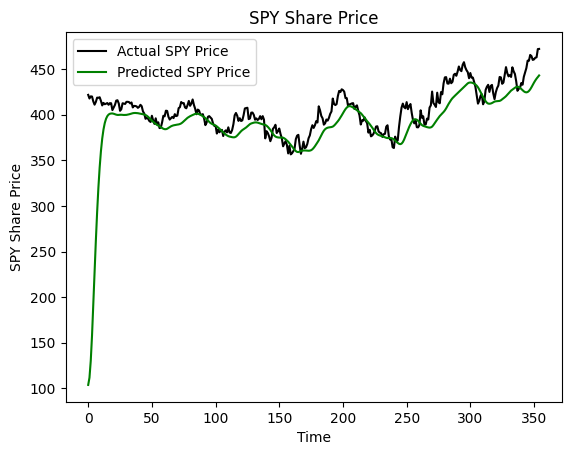

In [262]:
# Plot the prediction

plt.plot(actual_prices, color = 'black', label = f'Actual {company} Price')
plt.plot(predicted_prices, color = 'green', label = f'Predicted {company} Price')
plt.title(f'{company} Share Price')
plt.xlabel('Time')
plt.ylabel(f'{company} Share Price')
plt.legend()
plt.show();

In [87]:
# Predict Next Day

# selects a slice of model_inputs that corresponds to the most recent 
# prediction_days data points. 
# This represents the input data for which you want to make predictions.
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs + 1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

In [88]:
print(scaler.inverse_transform(real_data[-1]))V

[[328.607]
 [330.753]
 [329.518]
 [328.91 ]
 [336.162]
 [332.233]
 [338.486]
 [336.418]
 [333.958]
 [322.589]
 [318.493]
 [320.473]
 [323.315]
 [326.932]
 [314.956]
 [315.465]
 [323.089]
 [326.765]
 [329.666]
 [321.649]
 [332.517]
 [341.122]
 [331.448]
 [332.419]
 [335.418]
 [337.143]
 [340.084]
 [350.794]
 [354.588]
 [350.981]
 [353.725]
 [361.046]
 [364.908]
 [360.585]
 [358.684]
 [358.155]
 [349.658]
 [353.725]
 [354.705]
 [345.562]
 [338.094]
 [332.262]
 [333.869]
 [332.772]
 [334.565]
 [335.066]
 [339.153]
 [338.387]
 [345.287]
 [371.15 ]
 [380.754]
 [380.274]
 [392.692]
 [388.91 ]
 [387.292]
 [386.723]
 [388.38 ]
 [397.003]
 [385.165]]


In [89]:
prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction: {prediction}")

1/1 [==============================] - 1s 946ms/step
Prediction: [[378.83273]]
